In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
import time
from ae_train import *
from losses import *


In [298]:
importlib.reload(AE_Stats)

<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/AE_Dev/AE_Stats.py'>

In [2]:
path = 'MIT_TTbar'
prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

data = []
for p in prefixed:
    data.append([torch.load(f'{path}/{p}'),p])
data_smol = []
for d in data:
    non = torch.count_nonzero(d[0][:,0:48],dim =1)
    
    data_smol.append([d[0][non > 7],d[1]])

In [42]:
len(data)

82

In [63]:
path_cond = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/cond_AE_wafer_layer_split_mip_std_1_mean_nonzero_greater_7_tele_only_high_longer'
# path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero_all_old_model/'
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

models_cond = os.listdir(path_cond)
models = os.listdir(path)[9:]
def get_data(data,cur_model):
    cur_data = []
    for d in data:
        if d[1] == cur_model:
            cur_data = d[0]
            break
    return cur_data


In [64]:
len(models_cond)

43

In [65]:
len(models)

82

In [44]:
old_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/saved_trained_models/wafer_layer_split_mip_std_1_mean_nonzero'

test_set = []
pred_set = []
models_calced = []
for m in models:
    models_calced.append(m)
    cur_model = torch.load(os.path.join(old_path,m)).to('cpu')
    cur_data = get_data(data,m).to('cpu')
    if len(cur_data)< 10000:
        test_data = cur_data[-int(0.19*len(cur_data)):]
        test_set.append(test_data)
        pred_set.append(cur_model(test_data[:,0:48]))
    else:
        test_data = cur_data[-int(0.19*10000):]
        test_set.append(test_data)
        pred_set.append(cur_model(test_data[:,0:48]))
    
stats_per_old = []
for i in range(len(pred_set)):
    stats_per_old.append(AE_MSE(pred_set[i],test_set[i][:,0:48]).item()*3.5280**2)
    print(f'model {models_calced[i]} has MSE of {stats_per_old[i]}')
    
    

model dt_norm_3_34 has MSE of 2.5835259284791947
model dt_norm_3_38 has MSE of 2.289294442199707
model dt_norm_1_1 has MSE of 0.5604066007647515
model dt_norm_1_3 has MSE of 25.27103373239136
model dt_norm_1_5 has MSE of 29.6230387197876
model dt_norm_1_7 has MSE of 22.615901881141664
model dt_norm_1_9 has MSE of 15.07399570829773
model dt_norm_1_11 has MSE of 9.652060336624146
model dt_norm_1_13 has MSE of 6.079885254718781
model dt_norm_1_15 has MSE of 4.614757688386917
model dt_norm_1_17 has MSE of 3.4279001135272984
model dt_norm_1_19 has MSE of 2.793783137223244
model dt_norm_1_21 has MSE of 2.1003434614791874
model dt_norm_1_23 has MSE of 1.6945884977817536
model dt_norm_1_25 has MSE of 1.6243554353113177
model dt_norm_1_27 has MSE of 0.9246025867323876
model dt_norm_1_29 has MSE of 2.806704753576279
model dt_norm_1_30 has MSE of 2.1432372778444293
model dt_norm_1_31 has MSE of 2.13350799754715
model dt_norm_1_32 has MSE of 1.8085948826351168
model dt_norm_1_33 has MSE of 1.68338

In [4]:
def Sort(sub_li):
 
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of
    # sublist lambda has been used
    sub_li.sort(key = lambda x: x[0])
    return sub_li

In [5]:
def manual_encode(wafer):
    latent = np.zeros(16)
    index = torch.nonzero(wafer)
    non_zero = wafer[index]
    latent[0] = 1234
    for i in range(len(non_zero)):
        c = non_zero[i]
        ind = index[i]
        latent[i+1] = c
        latent[i+8] = index[i]
    return torch.tensor(latent).float()
def manual_dencode(latent):
    if int(latent[0]) == 1234:
        wafer = np.zeros(48)
        for i in range(7):
            val = latent[i+1]
            if val == 0:
                break
            wafer[int(latent[i+8])] = val
        return torch.tensor(wafer).float()
class Conditional_AE(nn.Module):

    def __init__(self, model):
        super(Conditional_AE, self).__init__()

        self.model = model
        
    def forward(self, x):
        
        x_encoded = self.encode(x)
        x_reconstructed = self.decode(x_encoded)
        return x_reconstructed

    def encode(self, x):
        
        out = torch.zeros(len(x),16)
        for i in range(len(x)):
            c = x[i]
            if torch.count_nonzero(c) < 8:
                out[i] = manual_encode(c)
            else:
                out[i] = self.model.encode(c)        
        return out
    
    def decode(self, x):
        out = torch.zeros(len(x),48)
        
        for i in range(len(x)):
            c = x[i]
            if int(c[0]) == 1234:
                out[i] = manual_dencode(c)
            else:
                out[i] = self.model.decode(c)
        return out

In [66]:
test_set = []
pred_set = []
models_calced = []
for m in models:
    models_calced.append(m)
    if m in models_cond:
        print(m)
        trained_model = torch.load(os.path.join(path_cond,m)).to('cpu')
        cur_model = Conditional_AE(trained_model)
    else:
        trained_model = torch.load(os.path.join(path,m)).to('cpu')
        cur_model = trained_model
#     trained_model = torch.load(os.path.join(path,m)).to('cpu')
#     cur_model = Conditional_AE(trained_model)
    cur_data = get_data(data,m).to('cpu')
    if len(cur_data)< 10000:
        test_data = cur_data[-int(0.19*len(cur_data)):]
        test_set.append(test_data)
        pred_set.append(cur_model(test_data[:,0:48]))
    else:
        test_data = cur_data[-int(0.19*10000):]
        test_set.append(test_data)
        pred_set.append(cur_model(test_data[:,0:48]))
    
    

stats_per = []
sim_energy_avg = []
for i in range(len(pred_set)):
    stats_per.append(AE_MSE(pred_set[i],test_set[i][:,0:48]).item()*3.5280**2)
    print(f'model {models_calced[i]} has MSE of {stats_per[i]}')
    sim_energy_avg.append(torch.mean(test_set[i][:,-1]).item())

percent_perf = []
for i in range(len(pred_set)):
    percent_perf.append(torch.mean(torch.sum(pred_set[i]-test_set[i][:,0:48],dim=1)/torch.sum(test_set[i][:,0:48],dim=1)*100).item())
percent_pref = []
for i in range(len(pred_set)):
    s = torch.sum(test_set[i][:,0:48],dim=1)
    s[s ==0.0000] = 1
    percent_pref.append(torch.mean(torch.sum(pred_set[i]-test_set[i][:,0:48],dim=1)/s).item()*100)
    
non_zeros = []
for t in test_set:
    non_zeros.append(torch.count_nonzero(t[:,0:48]).item()/(len(t)))

dt_norm_3_36
dt_norm_3_30
dt_norm_3_31
dt_norm_3_33
dt_norm_3_35
dt_norm_3_37
dt_norm_3_27
dt_norm_3_29
dt_norm_3_32
dt_norm_3_34
dt_norm_3_38
dt_norm_1_27
dt_norm_1_29
dt_norm_1_30
dt_norm_1_31
dt_norm_1_32
dt_norm_1_33
dt_norm_2_27
dt_norm_2_29
dt_norm_2_30
dt_norm_2_31
dt_norm_2_32
dt_norm_2_34
dt_norm_2_35
dt_norm_2_36
dt_norm_2_37
dt_norm_2_38
dt_norm_2_39
dt_norm_2_40
dt_norm_2_41
dt_norm_2_42
dt_norm_2_43
dt_norm_2_44
dt_norm_2_45
dt_norm_3_39
dt_norm_3_40
dt_norm_3_41
dt_norm_3_42
dt_norm_3_43
dt_norm_3_44
dt_norm_3_45
dt_norm_3_46
dt_norm_3_47
model dt_norm_3_36 has MSE of 2.093477490735054
model dt_norm_3_30 has MSE of 7.384505383953095
model dt_norm_3_31 has MSE of 8.716524852069856
model dt_norm_3_33 has MSE of 3.94949911404419
model dt_norm_3_35 has MSE of 2.3184978627004624
model dt_norm_3_37 has MSE of 1.9531039160900117
model dt_norm_3_27 has MSE of 10.45173272878647
model dt_norm_3_29 has MSE of 4.055876683731079
model dt_norm_3_32 has MSE of 2.867326495645523
model dt

In [253]:
# stats_per_cond = stats_per

ValueError: operands could not be broadcast together with shapes (82,) (6,) 

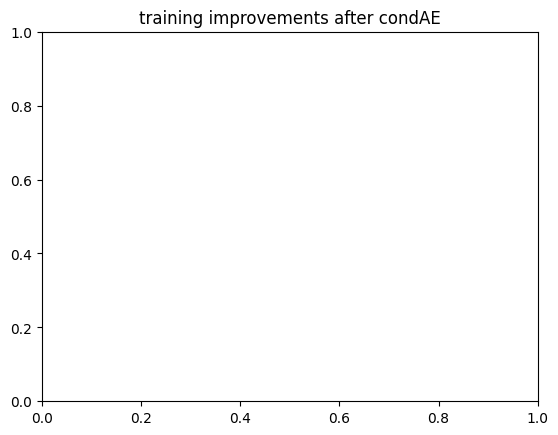

In [254]:
plt.title('training improvements after condAE')
plt.hist(np.array(stats_per_cond) - np.array(stats_per))
plt.show()

In [6]:
plt.hist(torch.count_nonzero(test_dt[:,0:48], dim =1))

NameError: name 'test_dt' is not defined

In [13]:
change = np.array(stats_per) - np.array(stats_per_old)

ValueError: operands could not be broadcast together with shapes (82,) (27,) 

In [14]:
plt.hist(change)
plt.title('Reduction in MSE from retraining AE models')
plt.xlabel('MSE change after retraining')
plt.show()

NameError: name 'change' is not defined

In [67]:
total_stats = []
for i in range(len(models)):
    total_stats.append([models[i],stats_per[i],sim_energy_avg[i],percent_pref[i],non_zeros[i]])

In [55]:
sorted_total_stats = Sort(total_stats)

In [56]:
sorted_total_stats

[['dt_norm_1_1',
  0.5604066007647515,
  1.8707172870635986,
  -0.9451139718294144,
  40.68157894736842],
 ['dt_norm_1_11',
  6.615787449050904,
  4.414220809936523,
  -0.8413000032305717,
  36.525263157894734],
 ['dt_norm_1_13',
  6.637808113426209,
  4.150584697723389,
  -0.806731078773737,
  34.92947368421053],
 ['dt_norm_1_15',
  4.614758059329987,
  3.970144271850586,
  -7.499077916145325,
  33.05736842105263],
 ['dt_norm_1_17',
  3.4279001135272984,
  3.7236273288726807,
  -7.904393225908279,
  31.453684210526315],
 ['dt_norm_1_19',
  2.7915289161901478,
  3.3295531272888184,
  -8.516231179237366,
  29.827894736842104],
 ['dt_norm_1_21',
  2.0913295448913574,
  3.247999668121338,
  -8.48742350935936,
  28.833157894736843],
 ['dt_norm_1_23',
  1.6880500697679521,
  2.8705122470855713,
  -7.835015654563904,
  27.91578947368421],
 ['dt_norm_1_25',
  1.6114558900709153,
  2.8637218475341797,
  -8.42730849981308,
  26.580526315789474],
 ['dt_norm_1_27',
  0.7953506271958352,
  2.50713

In [68]:
dt_1_total_stats = []
dt_2_total_stats = []
dt_3_total_stats = []
for t in total_stats:
    if int(t[0][8]) == 1:
        dt_1_total_stats.append(t)
    elif int(t[0][8]) == 2:
        dt_2_total_stats.append(t)
    else:
        dt_3_total_stats.append(t)

/tmp/ipykernel_203213/607527645.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


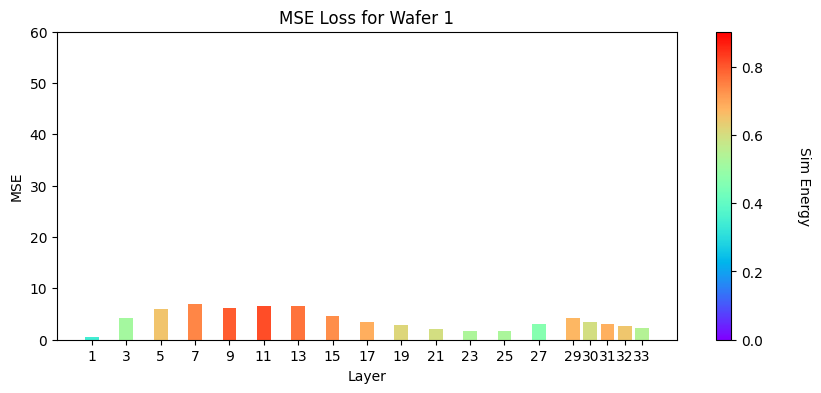

/tmp/ipykernel_203213/607527645.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


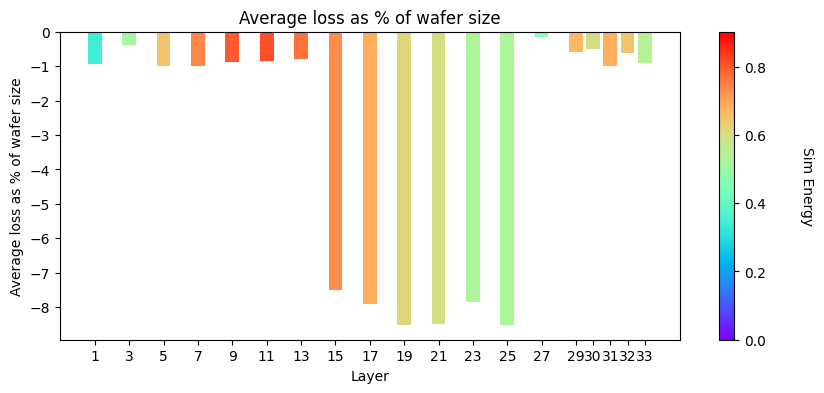

/tmp/ipykernel_203213/607527645.py:74: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


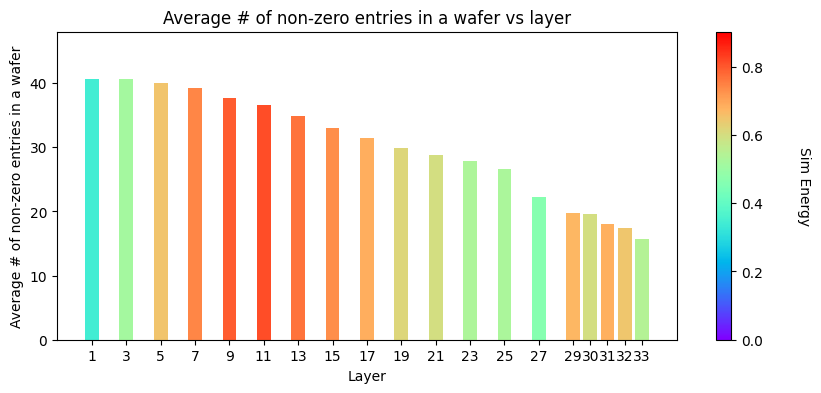

In [69]:
from matplotlib.cm import ScalarMappable
dt_1 = dt_1_total_stats
labeled = []
cur_sim = []
for d in dt_1:
    labeled.append([int(d[0][10:]),d[1],d[2],d[3],d[4]])
    
labeled_sorted = np.array(Sort(labeled))


for d in labeled_sorted:
    cur_sim.append(d[2])
max_sim = max(sim_energy_avg)

data_color = np.array(cur_sim)/max_sim

data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,1]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('MSE')
plt.xlabel('Layer')
plt.title('MSE Loss for Wafer 1')
plt.ylim([0,60])

plt.show()


data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,3]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average loss as % of wafer size')
plt.xlabel('Layer')
plt.title('Average loss as % of wafer size')

data_hight = labeled_sorted[:,4]

plt.show()

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average # of non-zero entries in a wafer')
plt.xlabel('Layer')
plt.ylim([0,48])
plt.title('Average # of non-zero entries in a wafer vs layer')

plt.show()

/tmp/ipykernel_203213/3238665122.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


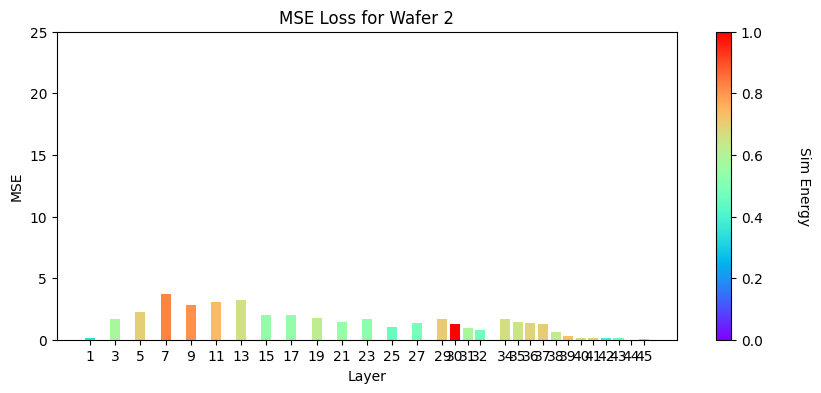

/tmp/ipykernel_203213/3238665122.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


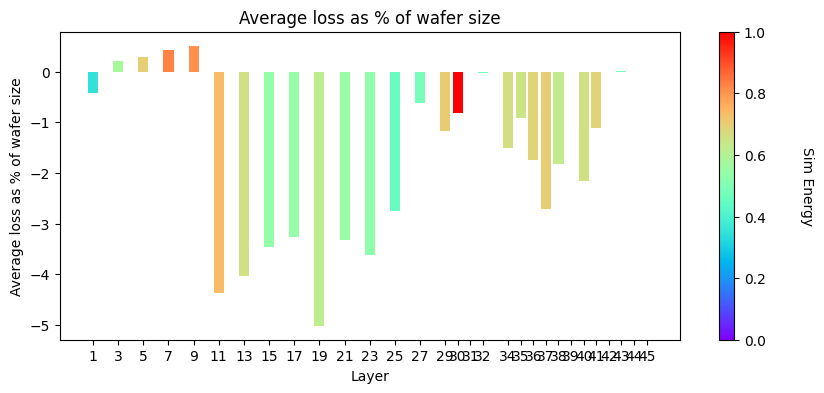

/tmp/ipykernel_203213/3238665122.py:75: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


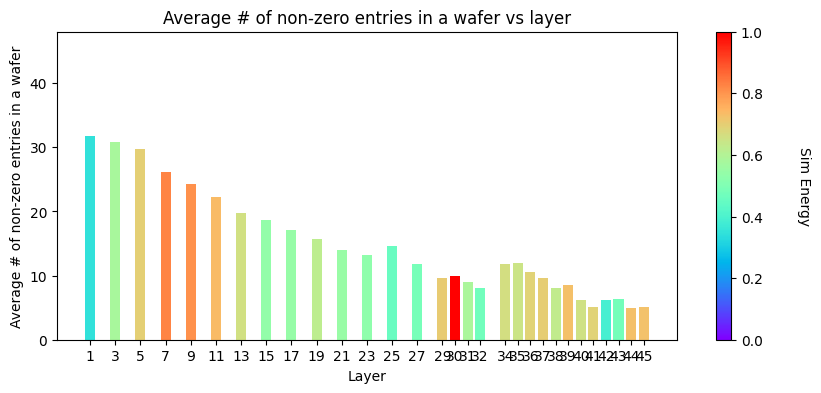

In [70]:
dt_2 = dt_2_total_stats

labeled = []
cur_sim = []
for d in dt_2:
    labeled.append([int(d[0][10:]),d[1],d[2],d[3],d[4]])
    
labeled_sorted = np.array(Sort(labeled))


for d in labeled_sorted:
    cur_sim.append(d[2])
max_sim = max(sim_energy_avg)

data_color = np.array(cur_sim)/max_sim

data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,1]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('MSE')
plt.xlabel('Layer')
plt.title('MSE Loss for Wafer 2')
plt.ylim([0,25])

plt.show()


data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,3]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average loss as % of wafer size')
plt.xlabel('Layer')
plt.title('Average loss as % of wafer size')
plt.show()

data_hight = labeled_sorted[:,4]

plt.show()

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average # of non-zero entries in a wafer')
plt.xlabel('Layer')
plt.ylim([0,48])
plt.title('Average # of non-zero entries in a wafer vs layer')

plt.show()

/tmp/ipykernel_203213/963865915.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


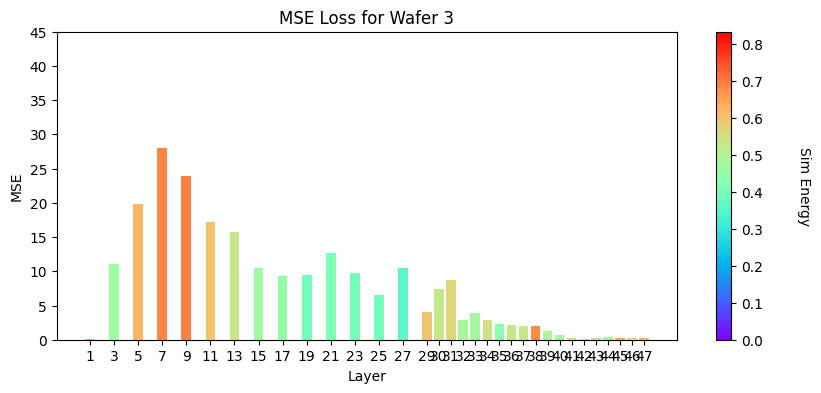

/tmp/ipykernel_203213/963865915.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


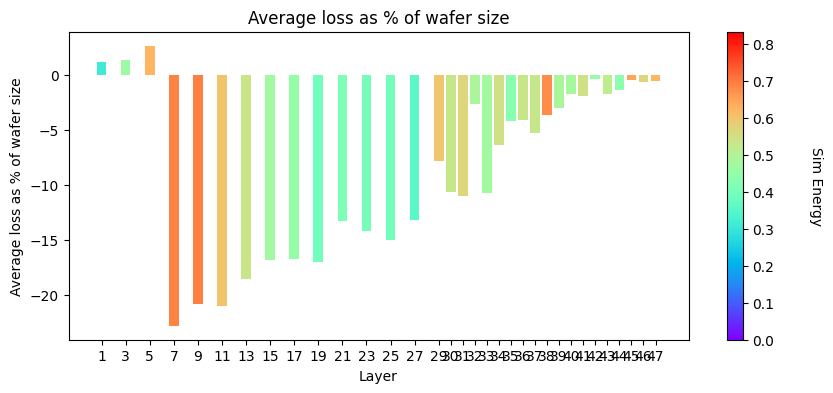

/tmp/ipykernel_203213/963865915.py:76: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


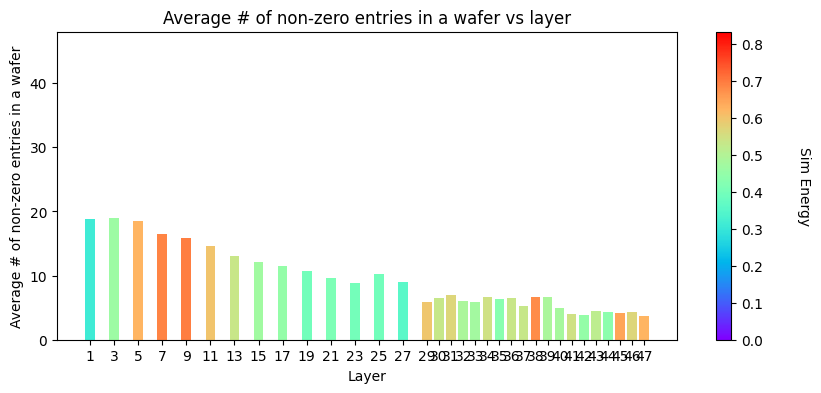

In [71]:
dt_3 = dt_3_total_stats

labeled = []
cur_sim = []
for d in dt_3:
    labeled.append([int(d[0][10:]),d[1],d[2],d[3],d[4]])
    
labeled_sorted = np.array(Sort(labeled))


for d in labeled_sorted:
    cur_sim.append(d[2])
max_sim = max(sim_energy_avg)

data_color = np.array(cur_sim)/max_sim

data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,1]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('MSE')
plt.xlabel('Layer')
plt.title('MSE Loss for Wafer 3')
plt.ylim([0,45])
plt.show()


data_x = labeled_sorted[:,0]
data_hight = labeled_sorted[:,3]

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average loss as % of wafer size')
plt.xlabel('Layer')
plt.title('Average loss as % of wafer size')

plt.show()


data_hight = labeled_sorted[:,4]

plt.show()

fig, ax = plt.subplots(figsize=(10, 4))

my_cmap = plt.cm.get_cmap('rainbow')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(data_color)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Sim Energy', rotation=270,labelpad=35)

plt.xticks(data_x)    
plt.ylabel('Average # of non-zero entries in a wafer')
plt.xlabel('Layer')
plt.ylim([0,48])
plt.title('Average # of non-zero entries in a wafer vs layer')

plt.show()

In [72]:
test_dt = torch.vstack(test_set)*3.5280
pred_dt = torch.vstack(pred_set)*3.5280

MSE 4.3048577308654785
Median 1.105904221534729
Standard Devitaion 16.38164520263672
Average std error 4.7311811447143555
Average % Error of Energy Reconstruction nan


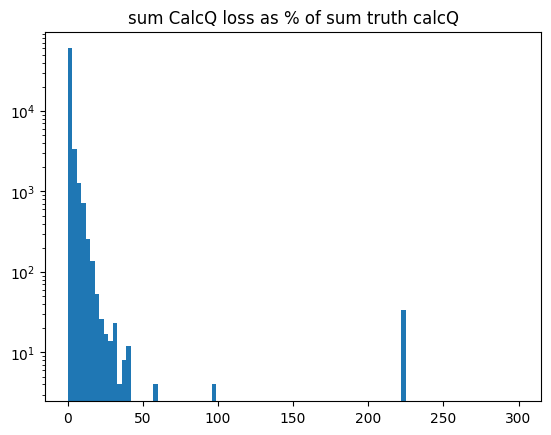

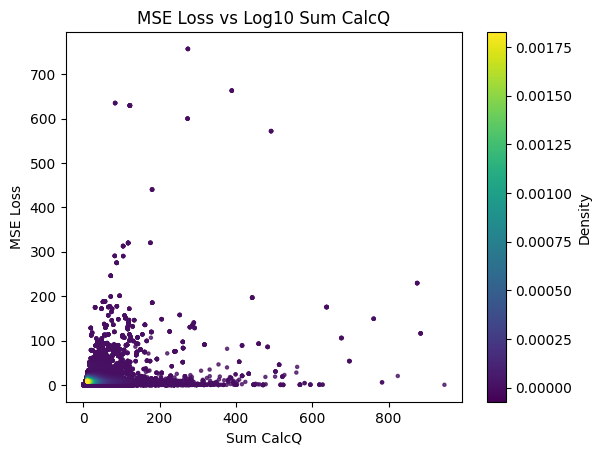

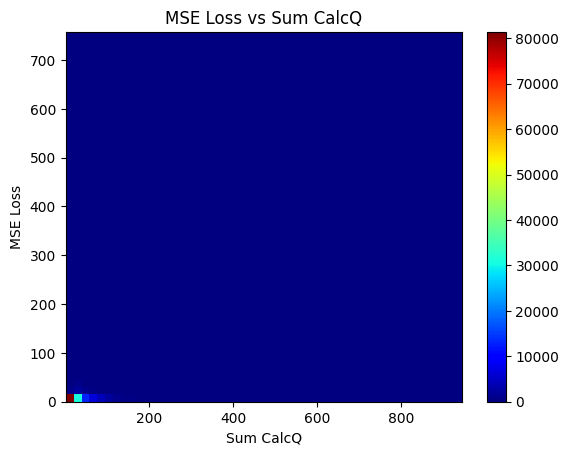

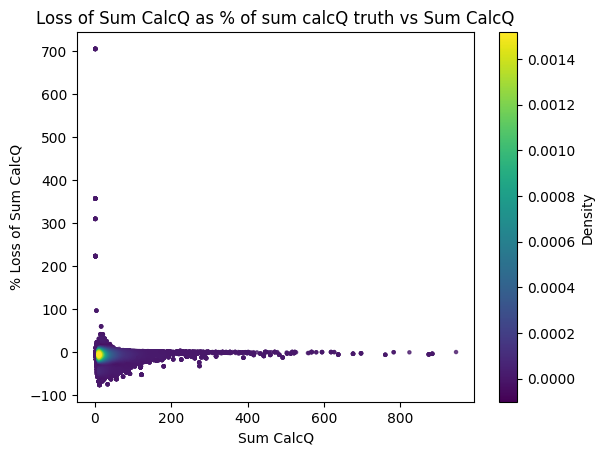

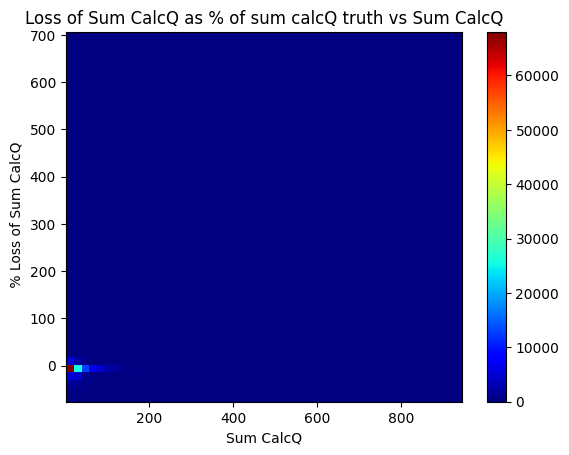

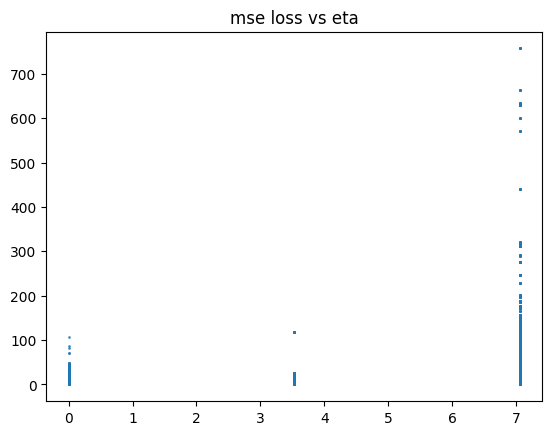

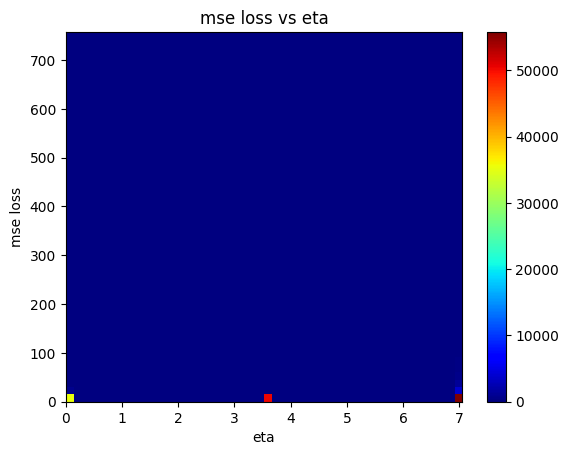

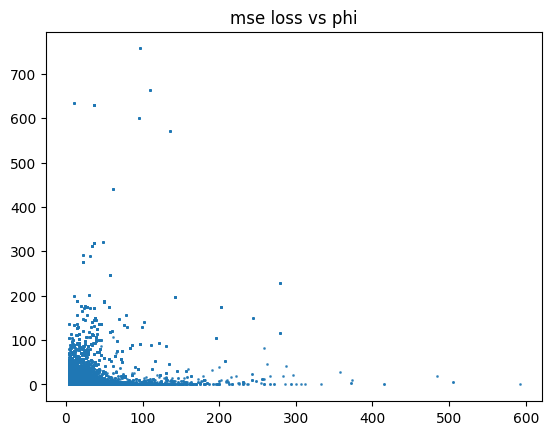

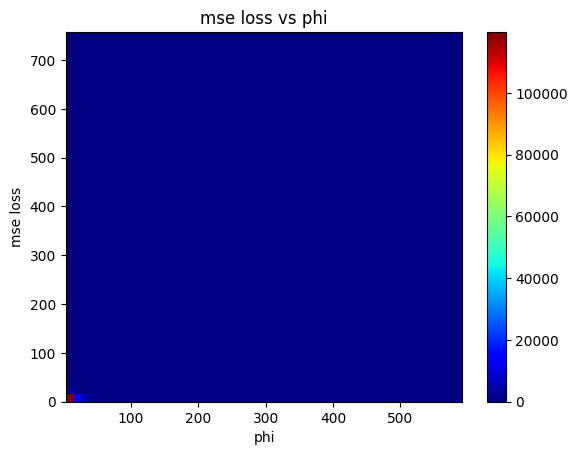

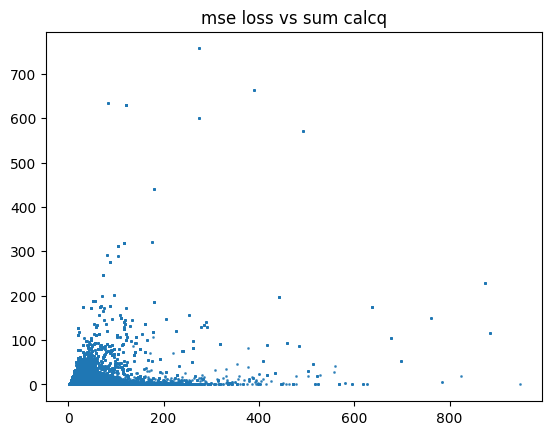

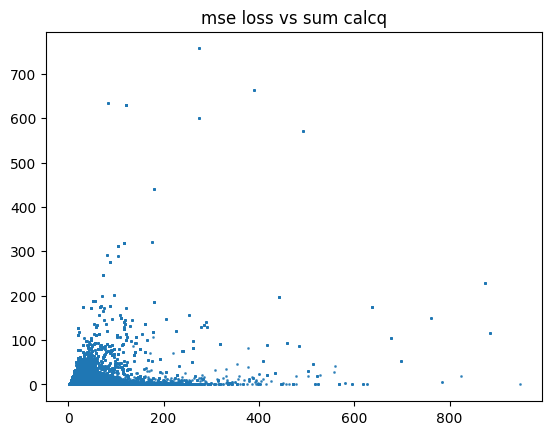

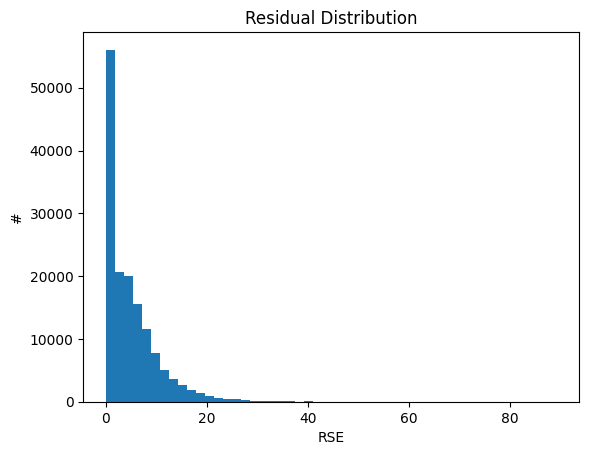

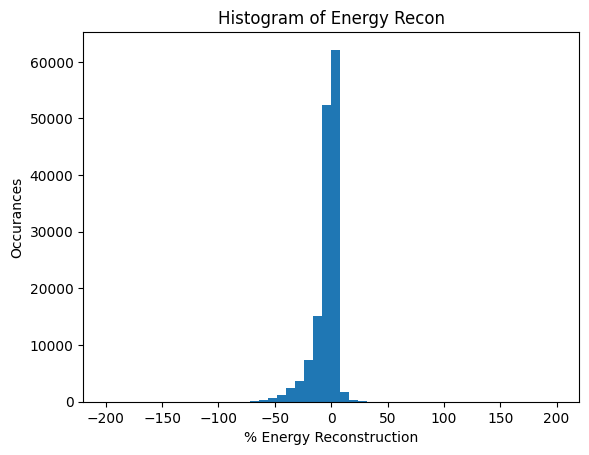

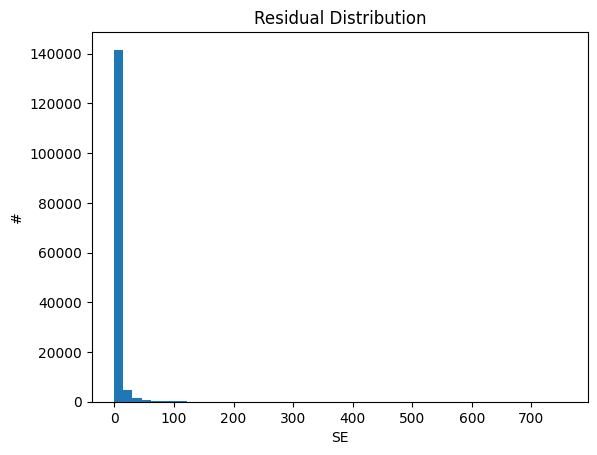

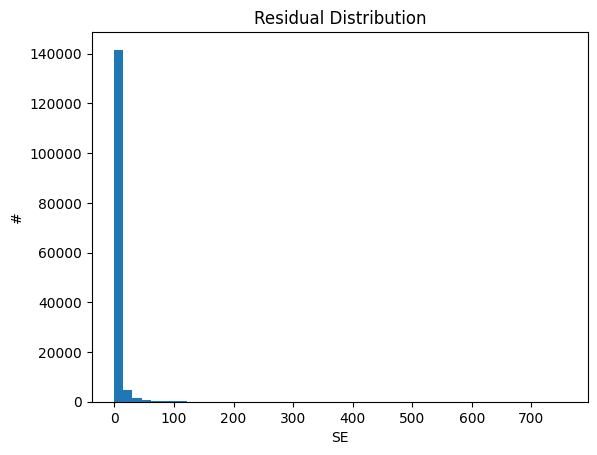

tensor([[ 7.0560, 21.1354, 15.1730,  0.0000,  0.0000],
        [ 7.0560, 14.6610, 12.5109,  0.0000,  0.0000],
        [ 7.0560, 48.5986, 42.1358,  0.1957,  0.8412],
        ...,
        [ 7.0560,  9.8844,  4.0301,  0.0000,  0.0000],
        [ 7.0560,  4.6137,  2.7633,  0.0000,  0.0000],
        [ 7.0560,  3.9591,  2.4775,  0.0000,  0.0000]], grad_fn=<CatBackward0>)

In [73]:
AE_Stats.generate_stats(pred_dt.cpu(),test_dt[:,0:48].cpu(),test_dt.cpu())

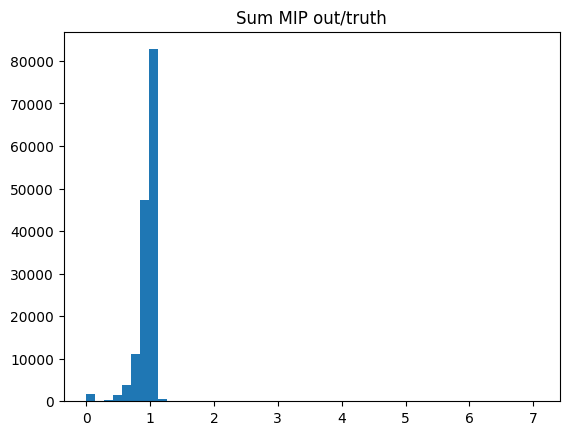

In [74]:

plt.title('Sum MIP out/truth')
t_sum =torch.sum(test_dt[:,0:48].cpu(),dim=1)
t_sum[t_sum == 0] = 1
plt.hist(torch.sum(pred_dt.cpu(), dim=1).detach().numpy()/t_sum.numpy(),bins = 50,log =False)
plt.show()